In [1]:
%cd ../../

/work/pancreas/psebe/assinaturas_mutacionais


In [2]:
import pymc3 as pm

In [3]:
import pandas as pd
import pymc3 as pm
import numpy as np
import seaborn as sns
import arviz as az
from matplotlib import pyplot as plt

## Data import

In [4]:
dtypes = dict(
    Tumor_Sample_Barcode=str,
    Chromosome="category",
    Start_Position=int,
    Reference_Allele="category",
    Tumor_Seq_Allele2="category",
    Hugo_Symbol=str,
    Consequence="category",
    Variant_Classification="category",
    DNA_VAF=float,
    Substitution="category"
)

In [5]:
mutations = pd.read_table("results/mutations_with_context.txt", dtype=dtypes, usecols=dtypes.keys())

In [6]:
mutational_catalogues = mutations.groupby(["Tumor_Sample_Barcode","Substitution"]).size().unstack(fill_value=0)

In [7]:
assert len(mutational_catalogues.columns) == 96

count    2683.000000
mean        3.930215
std         1.278081
min         0.000000
25%         3.258097
50%         4.007333
75%         4.634729
max         9.607370
dtype: float64

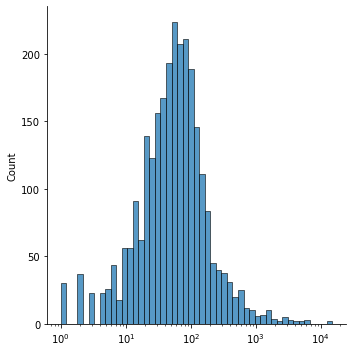

In [8]:
sns.displot(mutational_catalogues.sum(axis=1), log_scale=True)
np.log(mutational_catalogues.sum(axis=1)).describe()

In [9]:
info_clinica = pd.read_table(
    "resources/pancan_pcawg_2020/data_clinical_sample.txt",
    index_col="SAMPLE_ID",
    comment="#")

In [10]:
histology = info_clinica.loc[mutational_catalogues.index, "HISTOLOGY_ABBREVIATION"]

## COSMIC signatures import

In [11]:
sigs = pd.read_table("resources/COSMIC_v3.2_SBS_GRCh37.txt", index_col="Type").T

In [12]:
assert (sigs.columns == mutational_catalogues.columns).all()

## Statistical model

- ADVI
- Assinaturas fixas (COSMIC v3.2)
- Sem hiperdispersão
- Sem levar em conta tipo tumoral
- Priori uniforme

In [13]:
n = len(mutational_catalogues)
k, p = sigs.shape

In [14]:
coords = dict(
    Sample = mutational_catalogues.index,
    Signature = sigs.index,
    Substitution = sigs.columns
)

In [15]:
with pm.Model(coords=coords) as model:
    exposure = pm.Dirichlet("Exposure", np.ones((n,k)), dims=("Sample","Signature"))
    pm.Multinomial("Mutational catalogue",
                        n = mutational_catalogues.sum(axis=1),
                        p = pm.math.dot(exposure, sigs.values),
                        dims=("Sample", "Substitution"),
                        observed=mutational_catalogues.values)

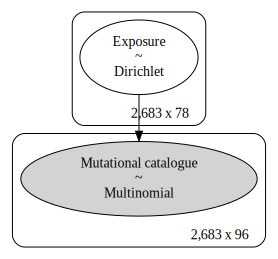

In [18]:
pm.model_to_graphviz(model)

In [16]:
with model:
    mean_field = pm.fit(
        n=2000,
        obj_optimizer=pm.adam(learning_rate=0.01),
        callbacks=[pm.callbacks.CheckParametersConvergence(every=50)])

Finished [100%]: Average Loss = 3.456e+05


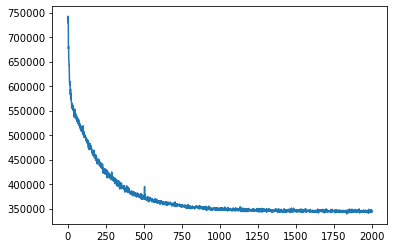

In [17]:
plt.plot(mean_field.hist)

In [18]:
trace = mean_field.sample()

## Análise

In [19]:
means = pd.DataFrame(
    trace["Exposure"].mean(axis=0),
    index = mutational_catalogues.index,
    columns = sigs.index
)

In [20]:
(
    means
    .groupby(histology)
    .mean()
    .stack()
    .reset_index()
    .sort_values(by=0, ascending=False)
    .head(15)
    .rename(columns={
        "HISTOLOGY_ABBREVIATION":"Histology",
        "level_1":"Signature",
        0:"Avg Exposure"})
)

,Histology,Signature,Avg Exposure
2580,Skin-Melanoma,SBS7a,0.273957
2581,Skin-Melanoma,SBS7b,0.221579
1248,ColoRect-AdenoCA,SBS1,0.217459
1326,Eso-AdenoCA,SBS1,0.170846
780,CNS-GBM,SBS1,0.153523
96,Bladder-TCC,SBS13,0.150129
2808,Stomach-AdenoCA,SBS1,0.141372
2340,Panc-AdenoCA,SBS1,0.128271
1092,Cervix-AdenoCA,SBS1,0.125559
79,Bladder-TCC,SBS2,0.114477


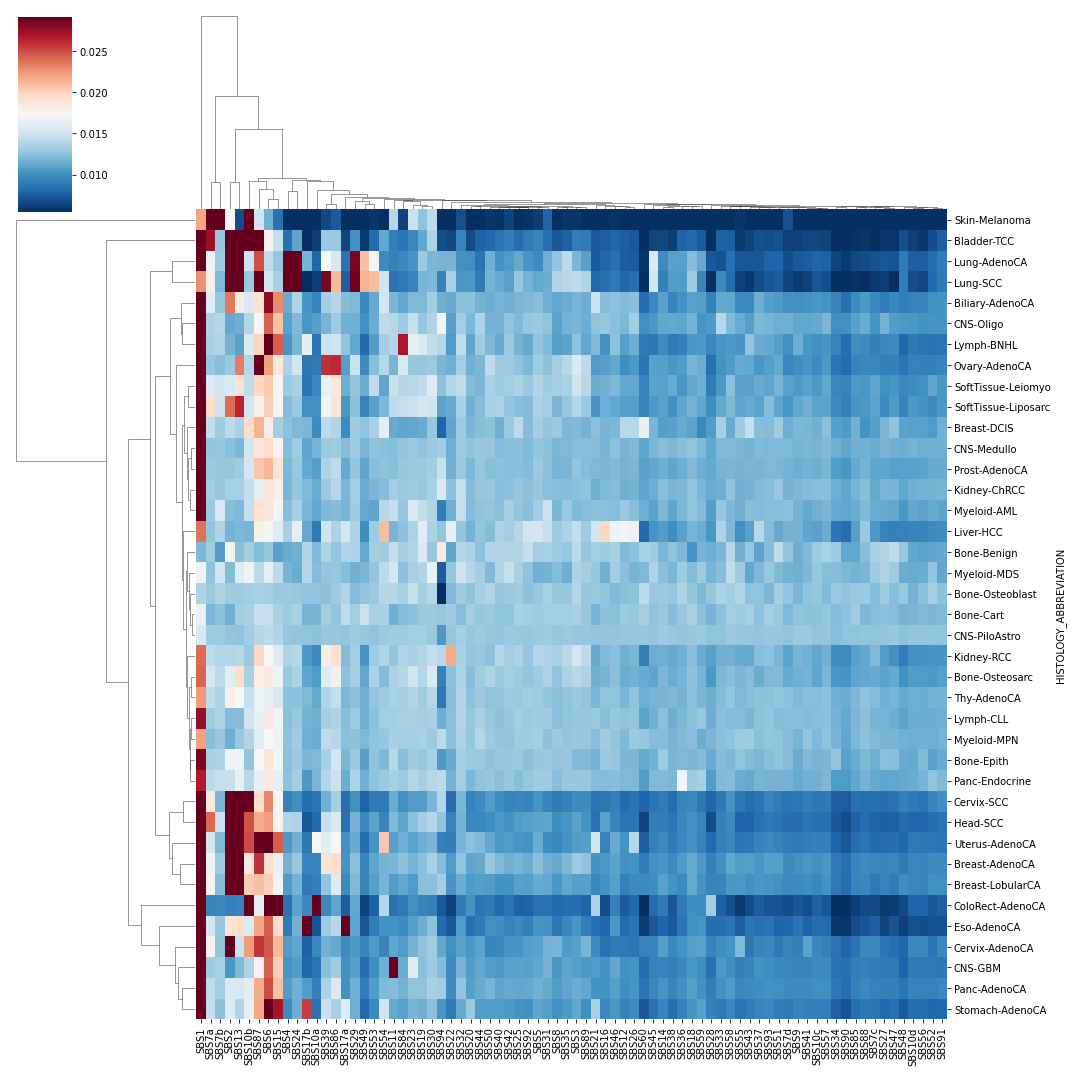

In [25]:
sns.clustermap(means.groupby(histology).mean(), robust=True, xticklabels=True, yticklabels=True,
                figsize=(15,15), cmap="RdBu_r")

In [23]:
presence = pd.DataFrame(
    (trace["Exposure"]>0.05).mean(axis=0),
    index = mutational_catalogues.index,
    columns = sigs.index
)

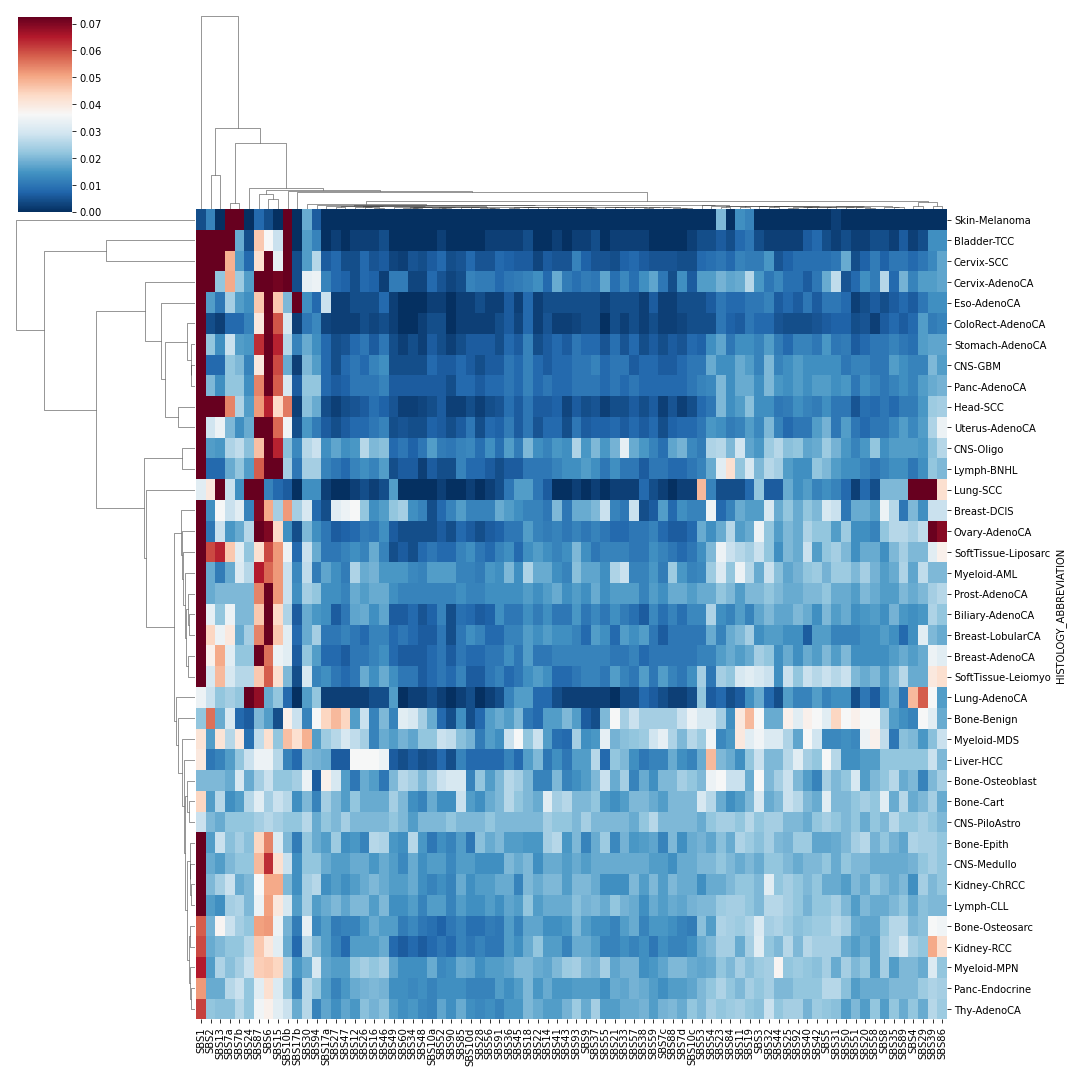

In [24]:
sns.clustermap(presence.groupby(histology).mean(), robust=True, xticklabels=True, yticklabels=True,
                figsize=(15,15), cmap="RdBu_r")